## 제주 빅데이터 경진대회
#### 이민혁
### Problem : 2020.04, 2020.07 기간 내 지역, 업종 별 월간 총 사용 금액 예측 
- 2019.01 ~ 2020.03 기간 내 카드 데이터, 201901-202003.csv (2.07 GB)
- 2020.04 기간 내 카드 데이터 (7/28 공개), 202004.csv (116 MB)
- 제출 양식, submission.csv (64 KB)


## 1. 라이브러리, 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('201901-202003.csv')
data2 = pd.read_csv('202004.csv')
df = pd.concat([data, data2])

In [3]:
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM HOM_CCG_NM  \
0          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
1          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
2          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
3          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
4          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
...           ...          ...         ...         ...         ...        ...   
1350317    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350318    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350319    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350320    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350321    202004           충북         충주시    휴양콘도 운영업          충북        충주시   

         AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0        20s            1    1          4   311200    4  
1        30s            1    2          7  1374500    8  
2        30s            2    2          6   818700    6  
3        40s            1    3          4  1717000    5  
4        40s            1    4          3  1047300    3  
...      ...          ...  ...        ...      ...  ...  
1350317  20s            1    1          5    77000    5  
1350318  30s            1    2          6    92000    6  
1350319  40s            2    3          5   193000    5  
1350320  50s            1    4          5    86000    7  
1350321  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

**데이터 설명**

REG__YYMM = 년월

CARD_SIDO_NM = 카드이용지역_시도 (가맹점 주소 기준)

CARD_CCG_NM = 카드이용지역_시군구 (가맹점 주소 기준)

STD_CLSS_NM = 업종명

HOM_SIDO_NM = 거주지역_시도 (고객 집주소 기준)

HOM_CCG_NM = 거주지역_시군구 (고객 집주소 기준)

AGE = 연령대

SEX_CTGO_CD = 성별 (1: 남성, 2: 여성)

FLC = 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

CSTMR_CNT = 이용고객수 (명)

AMT = 이용금액 (원)

CNT = 이용건수 (건)

## 2. EDA

#### 1) 결측값 확인

In [4]:
df.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      92371
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      155234
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

시군구 지역의 결측 값들이 존재한다.

In [5]:
df[df['HOM_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM   STD_CLSS_NM HOM_SIDO_NM  \
420        201901           강원         강릉시   과실 및 채소 소매업          세종   
421        201901           강원         강릉시   과실 및 채소 소매업          세종   
1189       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1190       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1191       201901           강원         강릉시  기타 대형 종합 소매업          세종   
...           ...          ...         ...           ...         ...   
1349960    202004           충북         충주시       한식 음식점업          세종   
1349961    202004           충북         충주시       한식 음식점업          세종   
1349962    202004           충북         충주시       한식 음식점업          세종   
1349963    202004           충북         충주시       한식 음식점업          세종   
1349964    202004           충북         충주시       한식 음식점업          세종   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
420            NaN  30s            1    2          3    58000    3  
421            NaN  40s            1    3          3   263000    4  
1189           NaN  20s            1    1          3   176540    3  
1190           NaN  20s            2    1          4   234880    6  
1191           NaN  30s            1    2          4   177640    5  
...            ...  ...          ...  ...        ...      ...  ...  
1349960        NaN  30s            2    2          3    80000    4  
1349961        NaN  40s            1    3         16   465400   19  
1349962        NaN  50s            1    4         33  1492450   50  
1349963        NaN  50s            2    4          3    30000    3  
1349964        NaN  60s            1    5          7   140800    9  

[155234 rows x 12 columns]

In [6]:
df[df['CARD_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM    STD_CLSS_NM HOM_SIDO_NM  \
1243710    201901           세종         NaN     건강보조식품 소매업          세종   
1243711    201901           세종         NaN     건강보조식품 소매업          세종   
1243712    201901           세종         NaN     건강보조식품 소매업          세종   
1243713    201901           세종         NaN     건강보조식품 소매업          세종   
1243714    201901           세종         NaN     건강보조식품 소매업          세종   
...           ...          ...         ...            ...         ...   
1040849    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040850    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040851    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040852    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040853    202004           세종         NaN  화장품 및 방향제 소매업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
1243710        NaN  30s            1    2         14  2737050   17  
1243711        NaN  30s            2    2         14  2595350   14  
1243712        NaN  40s            1    3         13  2531950   11  
1243713        NaN  40s            2    3         11  2118425   12  
1243714        NaN  50s            1    4         21  3025500   23  
...            ...  ...          ...  ...        ...      ...  ...  
1040849    청주시 흥덕구  50s            1    4          4   150800    4  
1040850    청주시 흥덕구  50s            2    4          3    72800    4  
1040851    청주시 흥덕구  60s            1    5          4    75100    4  
1040852    청주시 흥덕구  60s            2    5         10   194600   12  
1040853    청주시 흥덕구  70s            2    5          5   142000    5  

[92371 rows x 12 columns]

* 확인 결과 결측 값들은 세종시의 데이터이다.
* 세종시는 따로 시나 구가 존재하지 않기 때문이다.
* 따라서 새로운 시를 만들어서 하나의 그룹을 만들어 준다. 

In [7]:
df["CARD_CCG_NM"].fillna("세종시", inplace=True)
df["HOM_CCG_NM"].fillna("세종시", inplace=True)
df.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

**결측 값이 완전히 제거되었다**

#### 2) 날짜 처리

In [8]:
df['REG_YYMM'] = df['REG_YYMM'].astype(str)
df['REG_YYMM'] = df['REG_YYMM'].str[0:4] + "-" + df['REG_YYMM'].str[4:]
df['REG_YYMM'] = df['REG_YYMM'].astype('datetime64[ns]')
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM  \
0       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
1       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
2       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
3       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
4       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
...            ...          ...         ...         ...         ...   
1350317 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350318 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350319 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350320 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350321 2020-04-01           충북         충주시    휴양콘도 운영업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0              강릉시  20s            1    1          4   311200    4  
1              강릉시  30s            1    2          7  1374500    8  
2              강릉시  30s            2    2          6   818700    6  
3              강릉시  40s            1    3          4  1717000    5  
4              강릉시  40s            1    4          3  1047300    3  
...            ...  ...          ...  ...        ...      ...  ...  
1350317        충주시  20s            1    1          5    77000    5  
1350318        충주시  30s            1    2          6    92000    6  
1350319        충주시  40s            2    3          5   193000    5  
1350320        충주시  50s            1    4          5    86000    7  
1350321        충주시  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

#### 3) 상관관계 분석

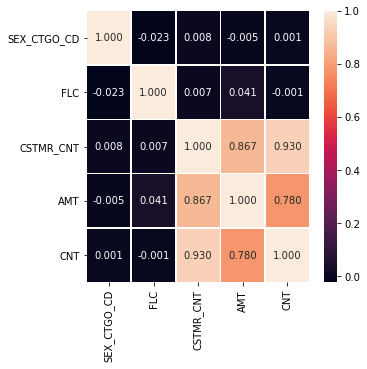

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.3f', linewidths=.5)

분석 결과 CSTMR_CNT와 CNT를 제외한 변수들은 AMT와의 상관도가 낮다.

In [10]:
DF = df.copy() 
DF = DF.drop(['HOM_SIDO_NM','CARD_CCG_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD', 'FLC','CSTMR_CNT','CNT'], axis=1)

In [11]:
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048114 rows x 4 columns]

#### 4) 이상한 데이터 제거

In [12]:
DF[DF['AMT']<2000]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM   AMT
234726   2019-01-01           경기           기타 대형 종합 소매업   900
877390   2019-01-01           서울              내항 여객 운송업   500
1001180  2019-01-01           서울                수산물 소매업  1000
1423635  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    40
1423637  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    90
...             ...          ...                    ...   ...
24126444 2020-03-01           서울  피자 햄버거 샌드위치 및 유사 음식점업  1600
24593106 2020-03-01           제주              정기 항공 운송업   300
63288    2020-04-01           경기           기타 대형 종합 소매업  1230
780409   2020-04-01           서울           그외 기타 종합 소매업  1600
1185267  2020-04-01           전북            차량용 주유소 운영업    30

[94 rows x 4 columns]

In [13]:
idx = DF[DF['AMT']<2000].index
DF = DF.drop(idx)
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048014 rows x 4 columns]

40원, 90원등 작은 금액이 결제된 데이터들이 보여 2000원 미만으로 결제된 목록을 알아보았다.

이상치를 완전히 제거하기 위해 2000원 미만의 데이터들을 삭제하였다.

#### 6) 데이터 묶음

In [14]:
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM','REG_YYMM']
DF = DF.groupby(columns).sum().reset_index(drop=False)
DF

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM        AMT
0               강원  건강보조식품 소매업 2019-01-01  148354746
1               강원  건강보조식품 소매업 2019-02-01  146715871
2               강원  건강보조식품 소매업 2019-03-01  109439025
3               강원  건강보조식품 소매업 2019-04-01  106548473
4               강원  건강보조식품 소매업 2019-05-01  148115738
...            ...         ...        ...        ...
10043           충북    휴양콘도 운영업 2019-12-01  139568962
10044           충북    휴양콘도 운영업 2020-01-01  222073112
10045           충북    휴양콘도 운영업 2020-02-01   47085830
10046           충북    휴양콘도 운영업 2020-03-01   12733490
10047           충북    휴양콘도 운영업 2020-04-01    9328420

[10048 rows x 4 columns]

#### 7) 업종 별 결측값 확인

In [41]:
len_STD = pd.DataFrame(data = DF['STD_CLSS_NM'].value_counts())
len_STD = len_STD[len_STD['STD_CLSS_NM'] < 272]
len_STD

STD_CLSS_NM
마사지업                          271
관광 민예품 및 선물용품 소매업             270
호텔업                           255
그외 기타 스포츠시설 운영업               253
자동차 임대업                       248
기타 수상오락 서비스업                  227
여행사업                          215
택시 운송업                        189
내항 여객 운송업                     179
버스 운송업                        175
휴양콘도 운영업                      160
면세점                           112
정기 항공 운송업                      92
그외 기타 분류안된 오락관련 서비스업           58

2019년 1월부터 2020년 4월까지의 데이터가 모두 존재하면 272개 이다.

지역별로 없는 업종이 존재하는 걸로 보인다.

In [55]:
len_CARD = pd.DataFrame()
for index in len_STD.index:
    DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == index])
    len_CARD[index] = DF_sample['CARD_SIDO_NM'].value_counts()
len_CARD

마사지업  관광 민예품 및 선물용품 소매업   호텔업  그외 기타 스포츠시설 운영업  자동차 임대업  기타 수상오락 서비스업  \
대전    16                 16  16.0               16     15.0            12   
인천    16                 16  16.0               16     15.0            16   
경북    16                 16  16.0               16     16.0            16   
광주    16                 16  16.0               16     16.0            14   
강원    16                 16  16.0               16     16.0            16   
제주    16                 16  16.0               12     16.0             9   
충남    16                 16  16.0               16     13.0            16   
전남    16                 16  16.0               16     16.0             2   
전북    16                 16  15.0               16     16.0            14   
경기    16                 16  16.0               16     16.0            16   
경남    16                 16  16.0               16     15.0            16   
부산    16                 16  16.0               16     16.0            16   
서울    16                 16  16.0               16     16.0            16   
울산    16                 16  16.0               16     16.0            15   
충북    16                 16  16.0               16     14.0            16   
대구    16                 16  16.0               16     16.0            16   
세종    15                 14   NaN                1      NaN             1   

    여행사업  택시 운송업  내항 여객 운송업  버스 운송업  휴양콘도 운영업   면세점  정기 항공 운송업  \
대전   1.0     NaN        NaN     NaN       NaN   NaN        NaN   
인천  16.0    16.0       16.0     NaN       NaN  16.0       16.0   
경북  12.0    16.0       13.0    13.0      16.0   NaN        NaN   
광주  10.0    11.0       13.0    16.0       NaN   NaN        NaN   
강원  16.0    14.0       16.0    13.0      16.0   5.0        NaN   
제주  16.0     7.0       16.0     NaN      16.0  16.0       16.0   
충남  16.0     9.0       14.0     8.0      16.0   NaN       12.0   
전남  16.0     1.0       16.0    16.0      16.0  14.0        NaN   
전북  16.0    16.0        6.0    15.0      16.0   NaN       16.0   
경기  16.0    16.0       11.0    16.0      16.0   NaN        NaN   
경남  16.0    16.0       16.0    16.0      16.0   NaN        NaN   
부산  16.0    16.0       14.0    15.0      16.0  15.0       16.0   
서울  16.0    16.0       16.0    16.0       NaN  16.0       16.0   
울산  16.0     3.0        NaN    16.0       NaN   8.0        NaN   
충북   5.0    16.0       12.0     7.0      16.0   8.0        NaN   
대구  11.0    16.0        NaN     8.0       NaN  14.0        NaN   
세종   NaN     NaN        NaN     NaN       NaN   NaN        NaN   

    그외 기타 분류안된 오락관련 서비스업  
대전                   NaN  
인천                   NaN  
경북                   5.0  
광주                   NaN  
강원                   1.0  
제주                  10.0  
충남                  16.0  
전남                   3.0  
전북                   NaN  
경기                   4.0  
경남                  16.0  
부산                   NaN  
서울                   NaN  
울산                   2.0  
충북                   NaN  
대구                   NaN  
세종                   1.0

지역별로 예측을 한 뒤 데이터가 없는 업종은 제외한다.

#### 8) 레이블 인코딩

In [63]:
from sklearn.preprocessing import LabelEncoder

dtypes = DF.dtypes
encoders = {}
for column in DF.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(DF[column])
        encoders[column] = encoder
        
df_num = DF.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(DF[column])

In [64]:
df_num

CARD_SIDO_NM  STD_CLSS_NM   REG_YYMM        AMT
0                 0            0 2019-01-01  148354746
1                 0            0 2019-02-01  146715871
2                 0            0 2019-03-01  109439025
3                 0            0 2019-04-01  106548473
4                 0            0 2019-05-01  148115738
...             ...          ...        ...        ...
10043            16           40 2019-12-01  139568962
10044            16           40 2020-01-01  222073112
10045            16           40 2020-02-01   47085830
10046            16           40 2020-03-01   12733490
10047            16           40 2020-04-01    9328420

[10048 rows x 4 columns]

## 3. Catboost Regressor

In [65]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

train_features = df_num.drop(['AMT'], axis=1)
train_target = np.log1p(df_num['AMT'])
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=0)

In [66]:
model = CatBoostRegressor(iterations=10000)
pool=Pool(data=X_train,label=y_train)
eval_set=(X_test,y_test)
model.fit(X_train,y_train,use_best_model=True,eval_set=eval_set)

Learning rate set to 0.016276
0:	learn: 2.9411542	test: 2.9269399	best: 2.9269399 (0)	total: 69.2ms	remaining: 11m 32s
1:	learn: 2.9306329	test: 2.9158626	best: 2.9158626 (1)	total: 71.9ms	remaining: 5m 59s
2:	learn: 2.9208941	test: 2.9067692	best: 2.9067692 (2)	total: 74.4ms	remaining: 4m 7s
3:	learn: 2.9114084	test: 2.8982490	best: 2.8982490 (3)	total: 77ms	remaining: 3m 12s
4:	learn: 2.9000542	test: 2.8864060	best: 2.8864060 (4)	total: 79.5ms	remaining: 2m 38s
5:	learn: 2.8883773	test: 2.8746812	best: 2.8746812 (5)	total: 82.3ms	remaining: 2m 17s
6:	learn: 2.8795912	test: 2.8654077	best: 2.8654077 (6)	total: 84.8ms	remaining: 2m 1s
7:	learn: 2.8701702	test: 2.8561956	best: 2.8561956 (7)	total: 87.3ms	remaining: 1m 49s
8:	learn: 2.8607859	test: 2.8468926	best: 2.8468926 (8)	total: 89.8ms	remaining: 1m 39s
9:	learn: 2.8512000	test: 2.8370833	best: 2.8370833 (9)	total: 92.5ms	remaining: 1m 32s
10:	learn: 2.8402716	test: 2.8259794	best: 2.8259794 (10)	total: 94.9ms	remaining: 1m 26s
11:

In [67]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test)
RMSE = mean_squared_error(y_test,preds)**0.5
print(RMSE)

0.48405157603270743


## 5. 예측

In [68]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
REG_YYMMs     = ['2020-07-01']

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for REG_YYMM in REG_YYMMs:
                temp.append([CARD_SIDO_NM, STD_CLSS_NM, REG_YYMM])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns= train_features.columns)
temp['REG_YYMM'] = temp['REG_YYMM'].astype('datetime64[ns]')

In [69]:
temp['CARD_SIDO_NM'] = pd.to_numeric(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = pd.to_numeric(temp['STD_CLSS_NM'])
temp.dtypes

CARD_SIDO_NM             int64
STD_CLSS_NM              int64
REG_YYMM        datetime64[ns]
dtype: object

In [70]:
# CatBoost 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]

In [71]:
temp

REG_YYMM  CARD_SIDO_NM  STD_CLSS_NM           AMT
0   2020-07-01             0            0  9.325012e+07
1   2020-07-01             0            1  2.245145e+09
2   2020-07-01             0            2  1.043259e+09
3   2020-07-01             0            3  1.489139e+07
4   2020-07-01             0            4  4.489300e+04
..         ...           ...          ...           ...
692 2020-07-01            16           37  1.822951e+10
693 2020-07-01            16           38  1.207139e+07
694 2020-07-01            16           39  4.170562e+08
695 2020-07-01            16           40  1.551044e+07
696 2020-07-01            16           30  5.388350e+06

[697 rows x 4 columns]

In [72]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [73]:
temp['REG_YYMM'] = temp['REG_YYMM'].astype(str)
temp['REG_YYMM'] = temp['REG_YYMM'].str[0:4] + temp['REG_YYMM'].str[5:7]
temp

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
0     202007           강원            건강보조식품 소매업  9.325012e+07
1     202007           강원               골프장 운영업  2.245145e+09
2     202007           강원           과실 및 채소 소매업  1.043259e+09
3     202007           강원     관광 민예품 및 선물용품 소매업  1.489139e+07
4     202007           강원  그외 기타 분류안된 오락관련 서비스업  4.489300e+04
..       ...          ...                   ...           ...
692   202007           충북               한식 음식점업  1.822951e+10
693   202007           충북                   호텔업  1.207139e+07
694   202007           충북         화장품 및 방향제 소매업  4.170562e+08
695   202007           충북              휴양콘도 운영업  1.551044e+07
696   202007           충북             정기 항공 운송업  5.388350e+06

[697 rows x 4 columns]

## 6. 정리

In [79]:
len_CARD

마사지업  관광 민예품 및 선물용품 소매업   호텔업  그외 기타 스포츠시설 운영업  자동차 임대업  기타 수상오락 서비스업  \
대전    16                 16  16.0               16     15.0            12   
인천    16                 16  16.0               16     15.0            16   
경북    16                 16  16.0               16     16.0            16   
광주    16                 16  16.0               16     16.0            14   
강원    16                 16  16.0               16     16.0            16   
제주    16                 16  16.0               12     16.0             9   
충남    16                 16  16.0               16     13.0            16   
전남    16                 16  16.0               16     16.0             2   
전북    16                 16  15.0               16     16.0            14   
경기    16                 16  16.0               16     16.0            16   
경남    16                 16  16.0               16     15.0            16   
부산    16                 16  16.0               16     16.0            16   
서울    16                 16  16.0               16     16.0            16   
울산    16                 16  16.0               16     16.0            15   
충북    16                 16  16.0               16     14.0            16   
대구    16                 16  16.0               16     16.0            16   
세종    15                 14   NaN                1      NaN             1   

    여행사업  택시 운송업  내항 여객 운송업  버스 운송업  휴양콘도 운영업   면세점  정기 항공 운송업  \
대전   1.0     NaN        NaN     NaN       NaN   NaN        NaN   
인천  16.0    16.0       16.0     NaN       NaN  16.0       16.0   
경북  12.0    16.0       13.0    13.0      16.0   NaN        NaN   
광주  10.0    11.0       13.0    16.0       NaN   NaN        NaN   
강원  16.0    14.0       16.0    13.0      16.0   5.0        NaN   
제주  16.0     7.0       16.0     NaN      16.0  16.0       16.0   
충남  16.0     9.0       14.0     8.0      16.0   NaN       12.0   
전남  16.0     1.0       16.0    16.0      16.0  14.0        NaN   
전북  16.0    16.0        6.0    15.0      16.0   NaN       16.0   
경기  16.0    16.0       11.0    16.0      16.0   NaN        NaN   
경남  16.0    16.0       16.0    16.0      16.0   NaN        NaN   
부산  16.0    16.0       14.0    15.0      16.0  15.0       16.0   
서울  16.0    16.0       16.0    16.0       NaN  16.0       16.0   
울산  16.0     3.0        NaN    16.0       NaN   8.0        NaN   
충북   5.0    16.0       12.0     7.0      16.0   8.0        NaN   
대구  11.0    16.0        NaN     8.0       NaN  14.0        NaN   
세종   NaN     NaN        NaN     NaN       NaN   NaN        NaN   

    그외 기타 분류안된 오락관련 서비스업  
대전                   NaN  
인천                   NaN  
경북                   5.0  
광주                   NaN  
강원                   1.0  
제주                  10.0  
충남                  16.0  
전남                   3.0  
전북                   NaN  
경기                   4.0  
경남                  16.0  
부산                   NaN  
서울                   NaN  
울산                   2.0  
충북                   NaN  
대구                   NaN  
세종                   1.0

**(1) 호텔업**

In [81]:
temp[temp['STD_CLSS_NM'] == '호텔업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM           AMT
37    202007           강원         호텔업  1.945632e+08
78    202007           경기         호텔업  7.440222e+07
119   202007           경남         호텔업  2.179323e+07
160   202007           경북         호텔업  4.632667e+07
201   202007           광주         호텔업  2.646867e+07
242   202007           대구         호텔업  7.078946e+07
283   202007           대전         호텔업  4.015292e+07
324   202007           부산         호텔업  4.647395e+08
365   202007           서울         호텔업  2.746710e+09
406   202007           세종         호텔업  1.426949e+07
447   202007           울산         호텔업  7.422835e+07
488   202007           인천         호텔업  2.287219e+08
529   202007           전남         호텔업  1.691156e+07
570   202007           전북         호텔업  1.093424e+06
611   202007           제주         호텔업  3.476469e+08
652   202007           충남         호텔업  3.619271e+07
693   202007           충북         호텔업  1.207139e+07

세종시는 호텔업 데이터가 없기 때문에 호텔업 데이터를 제거한다.

In [85]:
temp.iloc[406,3] = 0

In [86]:
temp[temp['STD_CLSS_NM'] == '호텔업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM           AMT
37    202007           강원         호텔업  1.945632e+08
78    202007           경기         호텔업  7.440222e+07
119   202007           경남         호텔업  2.179323e+07
160   202007           경북         호텔업  4.632667e+07
201   202007           광주         호텔업  2.646867e+07
242   202007           대구         호텔업  7.078946e+07
283   202007           대전         호텔업  4.015292e+07
324   202007           부산         호텔업  4.647395e+08
365   202007           서울         호텔업  2.746710e+09
406   202007           세종         호텔업  0.000000e+00
447   202007           울산         호텔업  7.422835e+07
488   202007           인천         호텔업  2.287219e+08
529   202007           전남         호텔업  1.691156e+07
570   202007           전북         호텔업  1.093424e+06
611   202007           제주         호텔업  3.476469e+08
652   202007           충남         호텔업  3.619271e+07
693   202007           충북         호텔업  1.207139e+07

**(2) 그외 기타 스포츠시설 운영업**

In [87]:
temp[temp['STD_CLSS_NM'] == '그외 기타 스포츠시설 운영업']

REG_YYMM CARD_SIDO_NM      STD_CLSS_NM         AMT
5     202007           강원  그외 기타 스포츠시설 운영업    441186.0
46    202007           경기  그외 기타 스포츠시설 운영업   6479157.0
87    202007           경남  그외 기타 스포츠시설 운영업   1153018.0
128   202007           경북  그외 기타 스포츠시설 운영업    671702.0
169   202007           광주  그외 기타 스포츠시설 운영업    898040.0
210   202007           대구  그외 기타 스포츠시설 운영업    542252.0
251   202007           대전  그외 기타 스포츠시설 운영업    314199.0
292   202007           부산  그외 기타 스포츠시설 운영업   2367967.0
333   202007           서울  그외 기타 스포츠시설 운영업  10895590.0
374   202007           세종  그외 기타 스포츠시설 운영업     39578.0
415   202007           울산  그외 기타 스포츠시설 운영업    628743.0
456   202007           인천  그외 기타 스포츠시설 운영업   2237630.0
497   202007           전남  그외 기타 스포츠시설 운영업   2252389.0
538   202007           전북  그외 기타 스포츠시설 운영업   1632908.0
579   202007           제주  그외 기타 스포츠시설 운영업    686422.0
620   202007           충남  그외 기타 스포츠시설 운영업   1271288.0
661   202007           충북  그외 기타 스포츠시설 운영업   1273821.0

세종시는 호텔업 데이터가 없기 때문에 호텔업 데이터를 제거한다.

In [85]:
temp.iloc[406,3] = 0

In [86]:
temp[temp['STD_CLSS_NM'] == '호텔업']

REG_YYMM CARD_SIDO_NM STD_CLSS_NM           AMT
37    202007           강원         호텔업  1.945632e+08
78    202007           경기         호텔업  7.440222e+07
119   202007           경남         호텔업  2.179323e+07
160   202007           경북         호텔업  4.632667e+07
201   202007           광주         호텔업  2.646867e+07
242   202007           대구         호텔업  7.078946e+07
283   202007           대전         호텔업  4.015292e+07
324   202007           부산         호텔업  4.647395e+08
365   202007           서울         호텔업  2.746710e+09
406   202007           세종         호텔업  0.000000e+00
447   202007           울산         호텔업  7.422835e+07
488   202007           인천         호텔업  2.287219e+08
529   202007           전남         호텔업  1.691156e+07
570   202007           전북         호텔업  1.093424e+06
611   202007           제주         호텔업  3.476469e+08
652   202007           충남         호텔업  3.619271e+07
693   202007           충북         호텔업  1.207139e+07